In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2

# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')



# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = {
    'agoda_hotel_reviews': (1, 10),  
    'tripadvisor_hotel_reviews': (1, 5),
    'klook_hotel_reviews': (1, 5),  
    'booking_hotel_reviews': (1, 10)
}

In [ ]:
# Function to load and normalize data
def load_and_normalize_data():
    all_reviews = []
    for directory, (min_score, max_score) in directories.items():           
        path = os.path.join('raw data', directory)
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])
                all_reviews.append(df)
    return pd.concat(all_reviews, ignore_index=True)

# Load and normalize data
df = load_and_normalize_data()

In [ ]:
# Function to lemmatize text
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Remove punctuation
    # You can translate punctuation to None (removing it)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenization
    tokens = nltk.word_tokenize(text)

    # Step 4: Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Step 5: Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return the processed text as a single string
    return ' '.join(lemmatized_tokens)

# Lemmatize the review content
df['cleaned_content'] = df['Review Content'].apply(preprocess_text)
# Convert normalized scores to binary labels (1 for positive, 0 for negative)
df['label'] = df['normalized_score'].apply(lambda x: 0 if x <= 0.25 else (2 if x >= 0.75 else 1))
print(df[['normalized_score', 'label']].describe())

In [ ]:
def count_labels(df):
    # Count the occurrences of each label
    positive_count = (df['label'] == 2).sum()
    negative_count = (df['label'] == 0).sum()
    neutral_count = (df['label'] == 1).sum()

    # Print the counts
    print(f'Positive reviews: {positive_count}')
    print(f'Negative reviews: {negative_count}')
    print(f'Neutral reviews: {neutral_count}')
    print(f"Total: {df['label'].count()}")
count_labels(df)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

def prepare_data(df, text_column, label_column, num_words=5000, maxlen=100, test_size=0.3, random_state=42):
    """
    Prepares the data for training by tokenizing the text and splitting the data into train and test sets.
    
    Parameters:
    - df (DataFrame): The input DataFrame containing the text and labels.
    - text_column (str): The name of the column containing the cleaned text.    
    - label_column (str): The name of the column containing the labels.
    - num_words (int): The maximum number of words to keep, based on word frequency.
    - maxlen (int): The maximum length of sequences.
    - test_size (float): The proportion of the dataset to include in the test split.
    - random_state (int): Controls the shuffling applied to the data before applying the split.
    
    Returns:
    - X_train (array): Padded sequences for the training data.
    - X_test (array): Padded sequences for the testing data.
    - y_train (Series): Labels for the training data.
    - y_test (Series): Labels for the testing data.
    - tokenizer (Tokenizer): The tokenizer fitted on the text data.
    """
    
    # Tokenization
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(df[text_column])

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(df[text_column])
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)

    # Prepare labels
    labels = df[label_column]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sequences, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test, tokenizer

# Assuming 'df' is your DataFrame with columns 'cleaned_content' and 'label'
X_train, X_test, y_train, y_test, tokenizer = prepare_data(df, text_column='cleaned_content', label_column='label')

In [ ]:
from tensorflow.keras.optimizers import Adam
def compile_train_evaluate(X_train, X_test, y_train, y_test, learning_rate, epochs):
    # Model creation
    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=100),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Corrected placement
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
    ])

    # Model Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Model Training
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2)
   
    # # Model Evaluation
    # loss, accuracy = model.evaluate(X_test, y_test)
    return model, history

In [ ]:
import pandas as pd          # For DataFrame creation
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns        # For heatmap generation

# Heatmap generation
def generate_heatmap(epochs, learning_rates, accuracy_results):
    accuracy_df = pd.DataFrame(accuracy_results, index=learning_rates, columns=epochs)
    
    plt.figure(figsize=(24, 16))
    sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap='coolwarm', cbar_kws={'label': 'Accuracy'})
    plt.title(f"Heatmap of Accuracy for Model")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()

In [ ]:
# Perform sentiment analysis and generate heatmaps
EPOCHS = 20

accuracy_results = []
val_accuracy_results= []
history_dict = {}
model_dict = {}
# Learning rates to try
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
epochs = list(range(EPOCHS))

for rate in learning_rates:
    print(f'Training with {rate} learning rate')
    model, history= compile_train_evaluate(X_train, X_test, y_train, y_test, rate, EPOCHS)
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    accuracy_results.append(accuracy)
    val_accuracy_results.append(val_accuracy)
    history_dict[rate] = history
    model_dict[rate] = model
    
print("Traning")
generate_heatmap(epochs, learning_rates, accuracy_results)
print("validation")
generate_heatmap(epochs, learning_rates, val_accuracy_results)


Traning


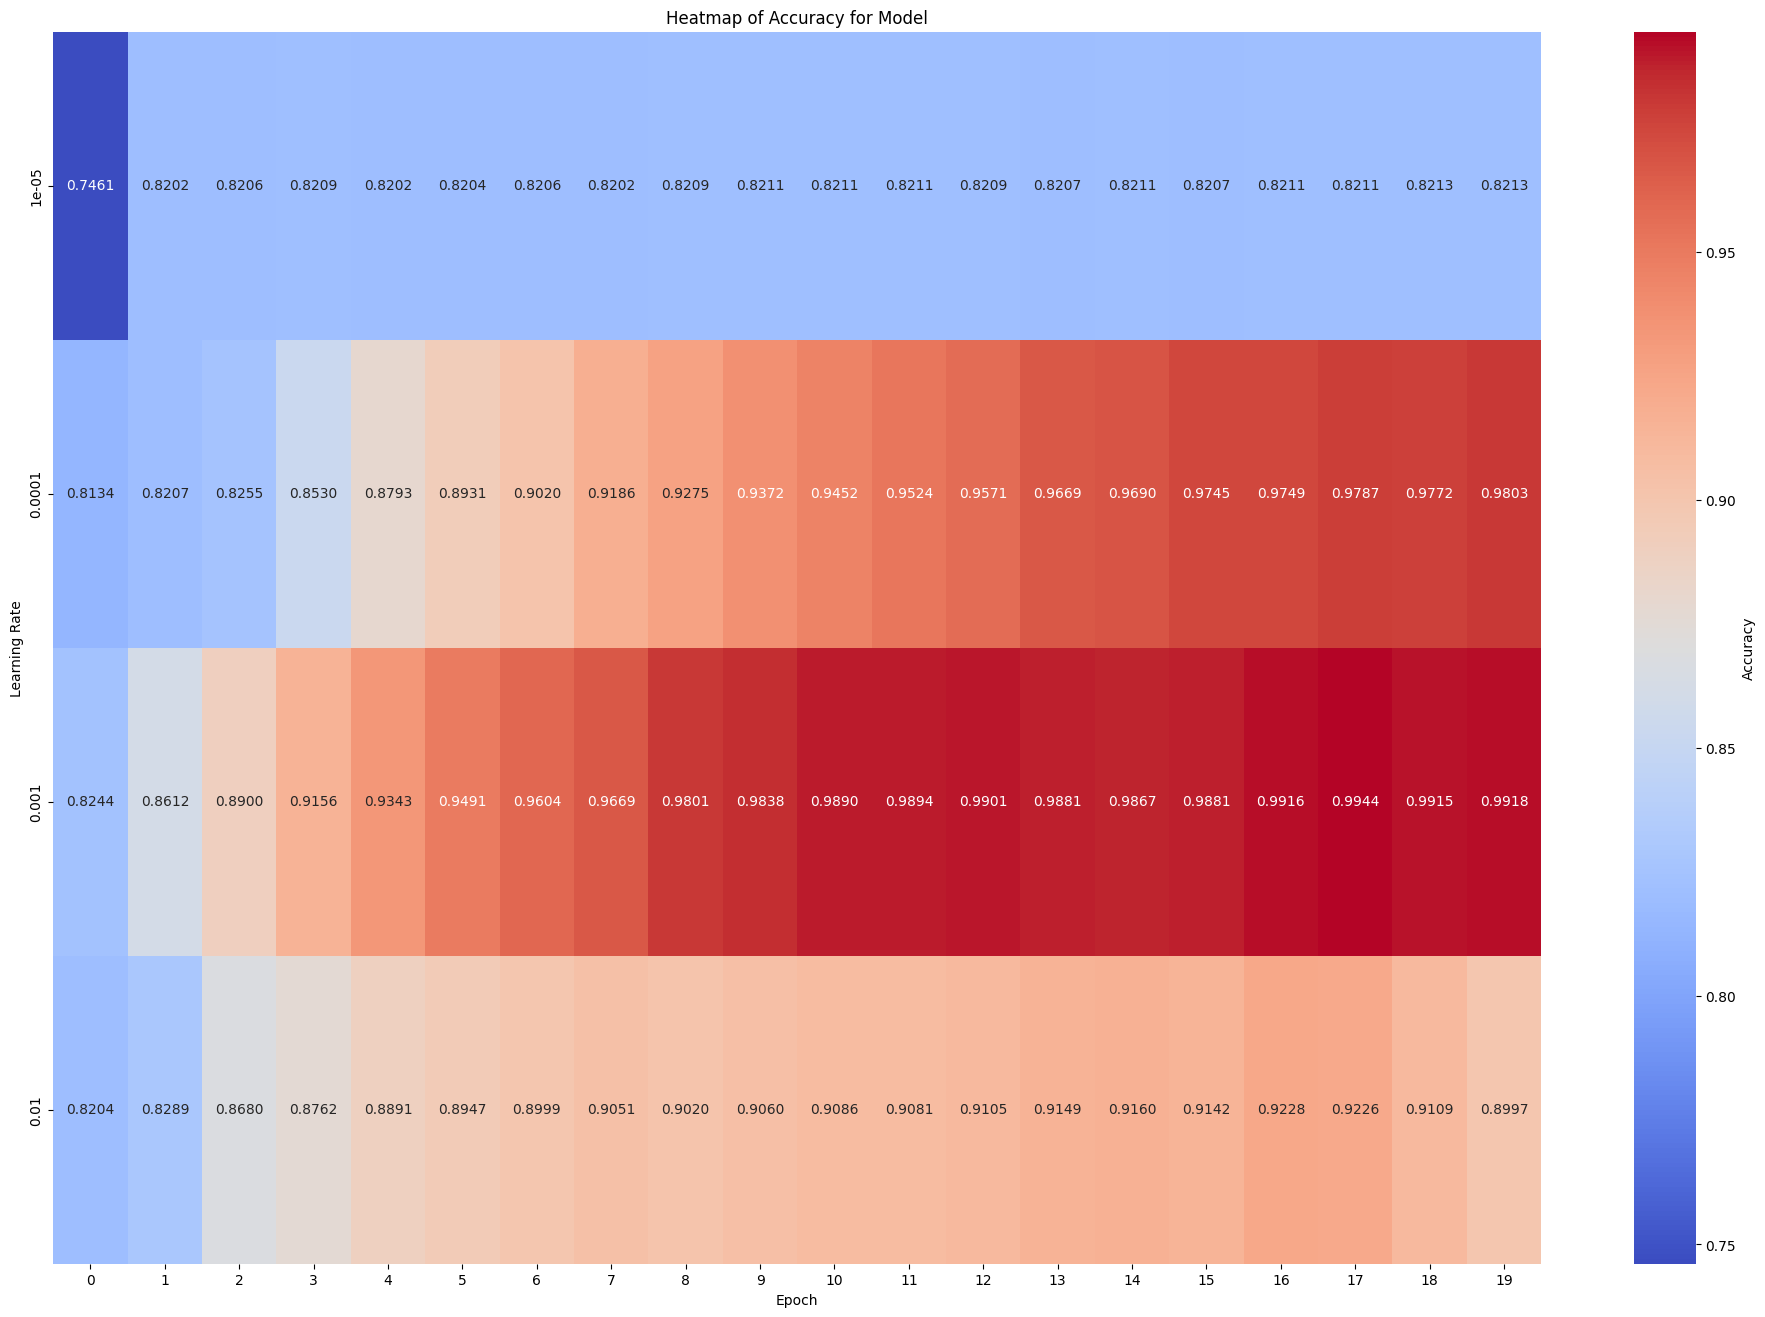

validation


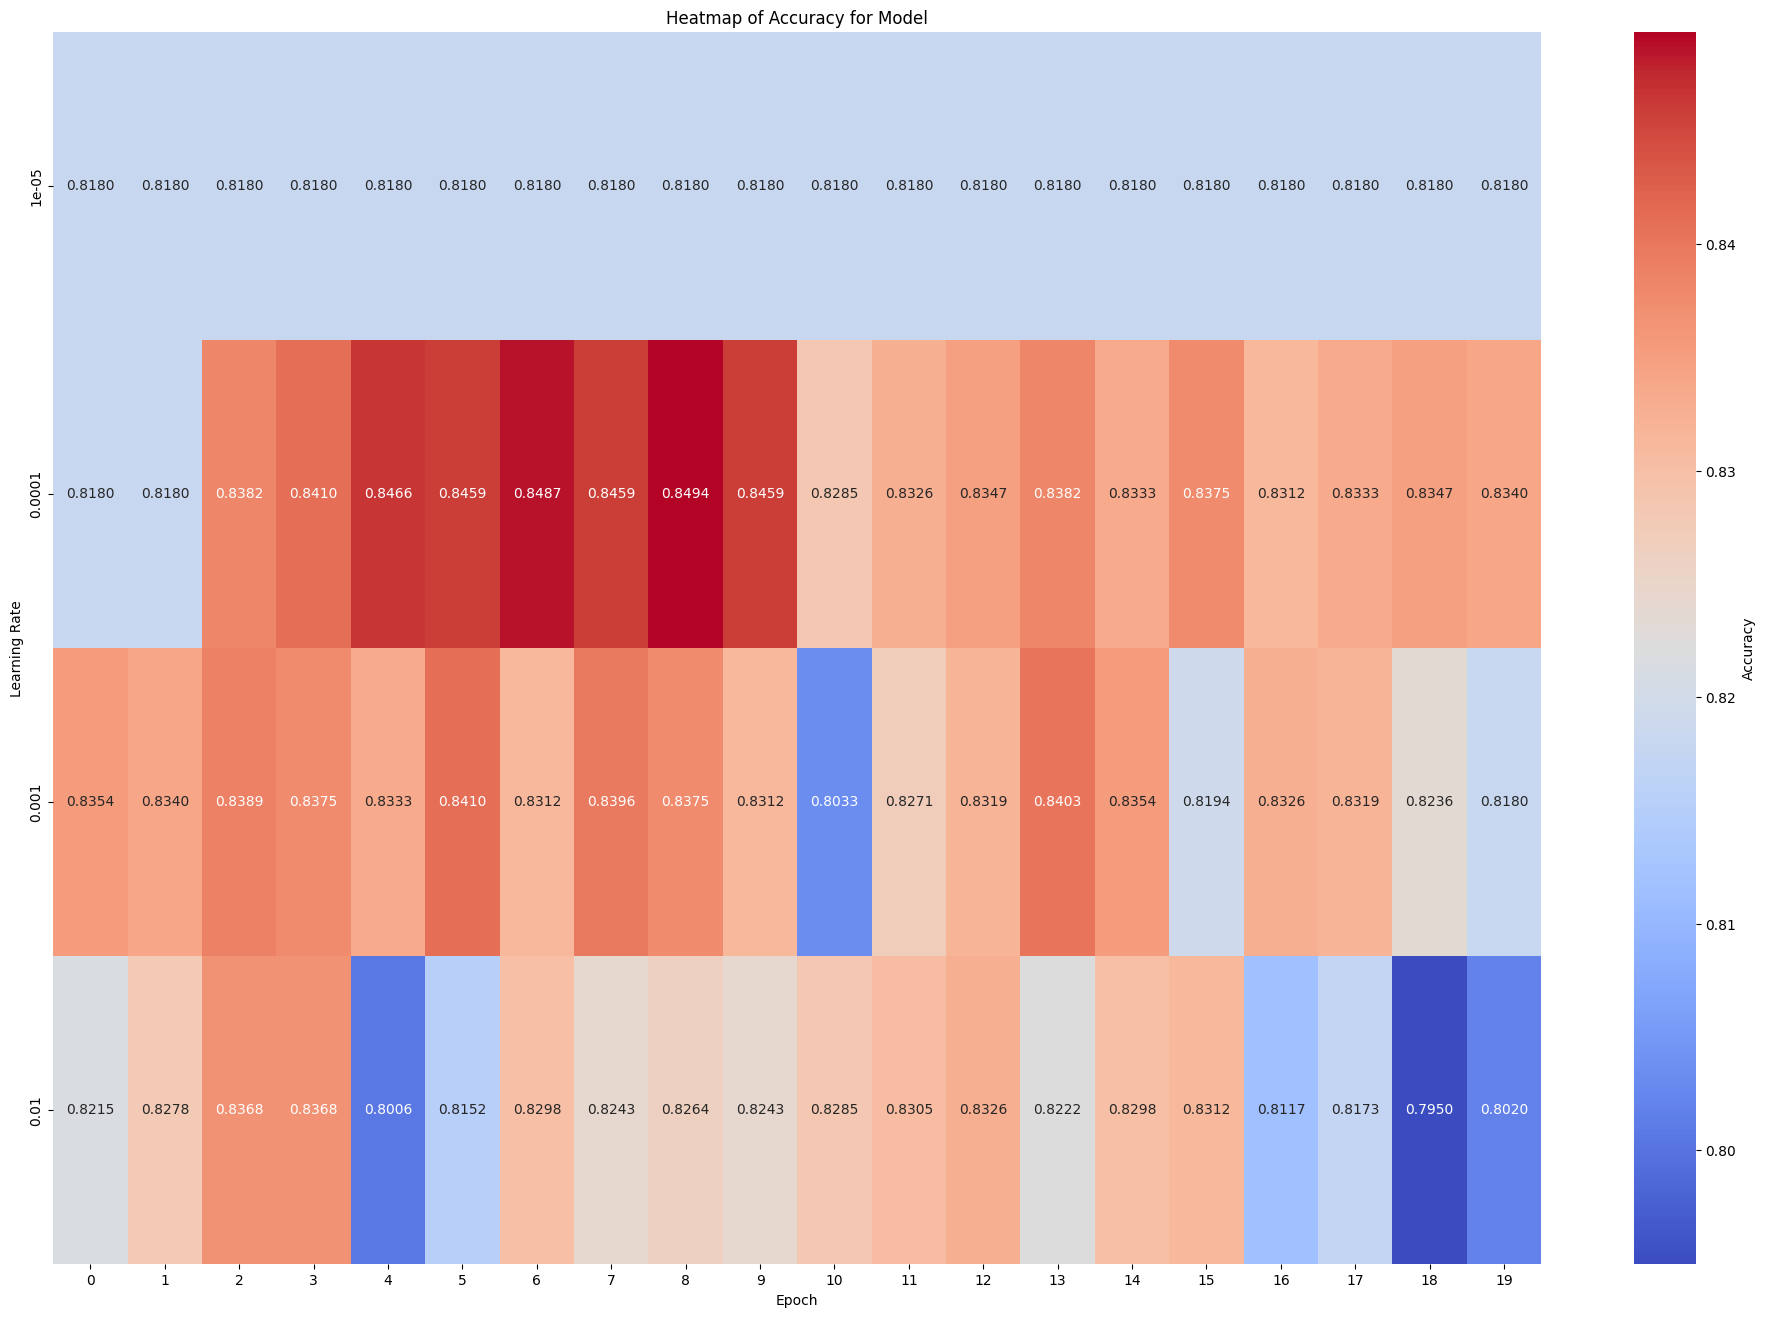

In [44]:
# Heatmap generation
def generate_heatmap2(epochs, learning_rates, accuracy_results):
    accuracy_df = pd.DataFrame(accuracy_results, index=learning_rates, columns=epochs)
    
    plt.figure(figsize=(24, 16))
    sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap='coolwarm', cbar_kws={'label': 'Accuracy'})
    plt.title(f"Heatmap of Accuracy for Model")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.show()
print("Traning")
generate_heatmap2(epochs, learning_rates, accuracy_results)
print("validation")
generate_heatmap2(epochs, learning_rates, val_accuracy_results)


In [52]:
# Plot training & validation accuracy and loss values
def plot_accuracy_loss(history, learning_rate):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Loss Over Epochs (LR: {learning_rate})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [53]:
for rate in learning_rates:
    print(f"rate: {rate}")
    plot_accuracy_loss(history_dict[rate], rate)

rate: 1e-05


TypeError: plot_accuracy_loss() missing 1 required positional argument: 'learning_rate'

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example input reviews
new_reviews = [
    {"review": "The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!", "score": 1.0},
    {"review": "The location was good, but the room had a strange smell and the service was just okay.", "score": 0.6},
    {"review": "I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.", "score": 0.2},
    {"review": "Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.", "score": 1.0},
    {"review": "The room was decent, but the Wi-Fi was slow and unreliable. It was an average stay overall.", "score": 0.5},
    {"review": "Terrible service! We waited over an hour for our room to be ready and the staff was not apologetic.", "score": 0.3},
    {"review": "The hotel was in a perfect location, close to all the major attractions. The room was comfortable and well-maintained.", "score": 0.9},
    {"review": "The facilities were outdated, and the air conditioning barely worked. I was disappointed with my stay.", "score": 0.4},
    {"review": "Great value for money! The hotel offered a lot of amenities and the staff was very friendly.", "score": 0.8},
    {"review": "The breakfast was good, but the room was small and the bed was uncomfortable. It was an okay stay.", "score": 0.6}
]

# Define a function to preprocess new input data
def preprocess_new_data(new_data):
    # Apply the same preprocessing function
    cleaned_data = [preprocess_text(entry["review"]) for entry in new_data]
    
    # Convert to sequences using the trained tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as your training data

    return padded_sequences

# Prepare reviews for prediction
padded_sequences = preprocess_new_data(new_reviews)

# Make predictions
predictions = model.predict(padded_sequences)

# Interpreting the predictions
for i, prediction in enumerate(predictions):
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_score = prediction[predicted_label]  # The probability of the predicted class
    actual_score = new_reviews[i]["score"]

    # Assign sentiment based on the predicted label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[predicted_label]

    # Print the results
    print(f"Review: {new_reviews[i]['review']}")
    print(f"Actual Score: {actual_score:.2f}")
    print(f"Predicted Label: {sentiment}")
    print(f"Negative Probability: {prediction[0]:.2f}")
    print(f"Neutral Probability: {prediction[1]:.2f}")
    print(f"Positive Probability: {prediction[2]:.2f}")
    print("-" * 50)

In [ ]:
from datetime import datetime
import os

# Assuming `model` is your Keras model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'saved_models/general_sentiment_softmax_{timestamp}.keras'

# Make sure the directory exists
os.makedirs(os.path.dirname(file_name), exist_ok=True)

# Save the model with the unique file name
model.save(file_name)
print(f"Model saved as {file_name}")
model.summary()